In [1]:
import pandas as pd
import numpy as np
import missingno as msno
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import helper

In [2]:
colors = ["#FF0B04", "#F1BE48",
           "#B9975B", "#8B5B29",
           "#524727",
         ]
sns.set_palette(sns.color_palette(colors))

In [3]:
# loading and splitting data
housing = pd.read_csv('ames_housing_latlong.csv', index_col = 0,
                      low_memory=False)

housing.drop_duplicates(inplace=True)
housing.reset_index(drop=True, inplace=True)

housing = housing[(housing['SaleCondition'] == 'Normal') | 
                   (housing['SaleCondition'] == 'Partial')].reset_index(drop=True)

train, test = helper.stratified_split(housing,'Neighborhood')

train, mapping_dict = helper.geo_cords_imputing(train)
test = helper.geo_cords_imputing(test,mapping_dict)

train = helper.data_processing_wrapper(train)
test = helper.data_processing_wrapper(test)

Dropping MasVnrArea from our data set.
Dropping GarageYrBlt from our data set.
Dropping MasVnrArea from our data set.
Dropping GarageYrBlt from our data set.


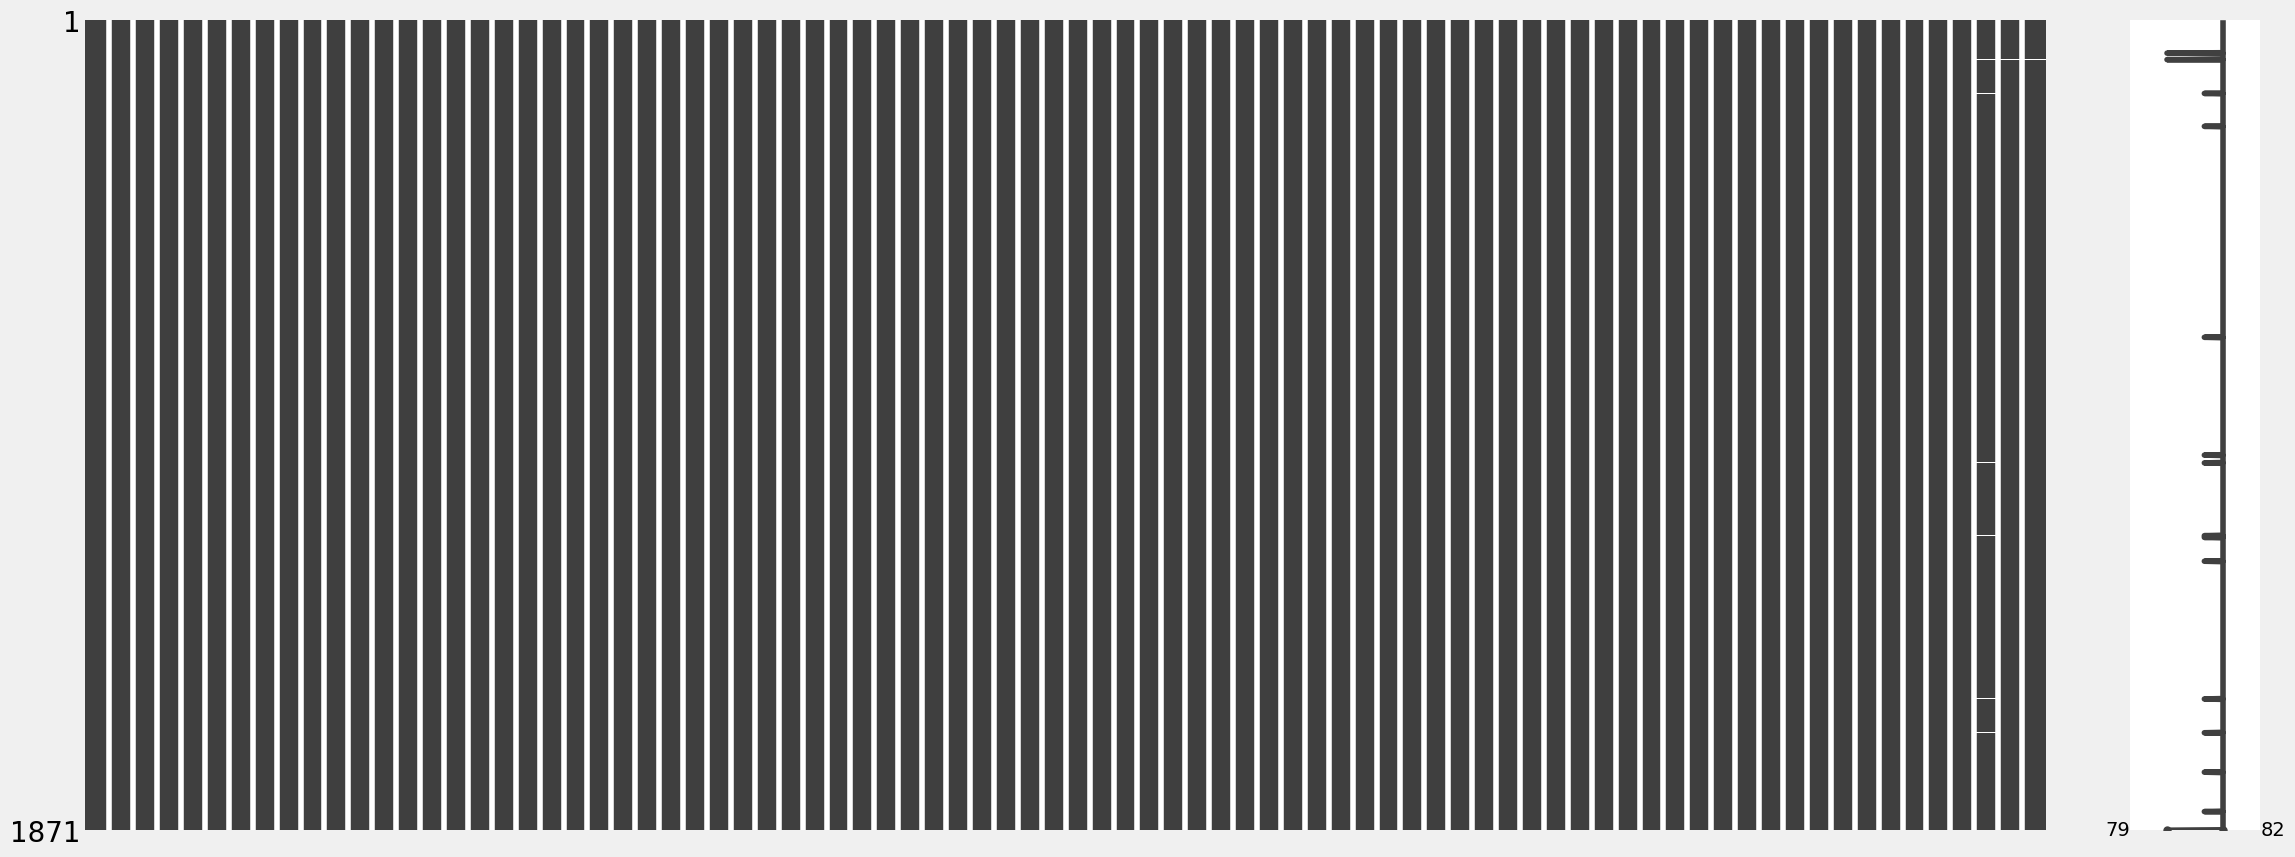

In [4]:
msno.matrix(train)
plt.show()

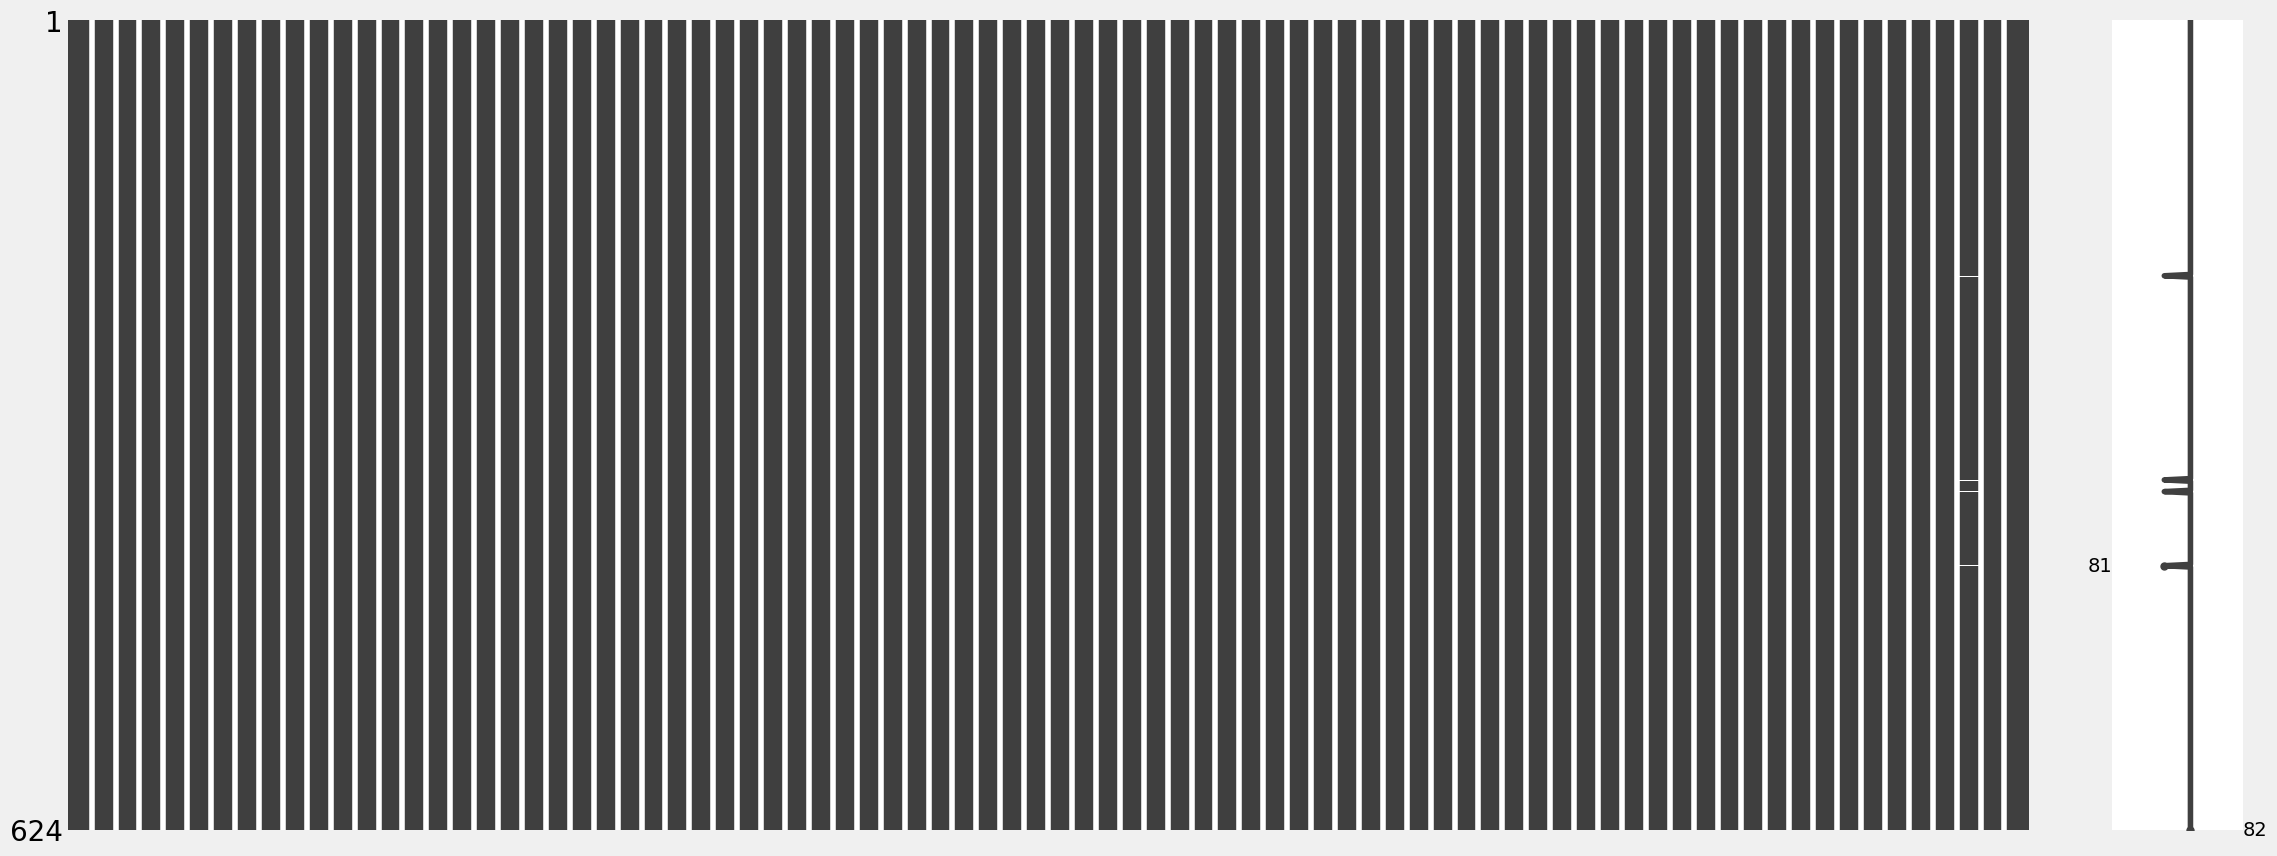

In [5]:
msno.matrix(test)
plt.show()

In [6]:
cols_na = train.loc[:,train.isna().any(axis=0)].columns.to_list()
cols_na

['Prop_Addr', 'latitude', 'longitude']

In [7]:
cols_na = test.loc[:,test.isna().any(axis=0)].columns.to_list()
cols_na

['Prop_Addr']

In [8]:
train.dropna(subset = ['latitude'],inplace=True)
train.drop(['Prop_Addr'], axis=1,inplace = True)
test.drop(['Prop_Addr'], axis=1,inplace = True)


In [9]:
cols_na = train.loc[:,train.isna().any(axis=0)].columns.to_list()
cols_na

[]

In [10]:
cols_na = test.loc[:,test.isna().any(axis=0)].columns.to_list()
cols_na

[]

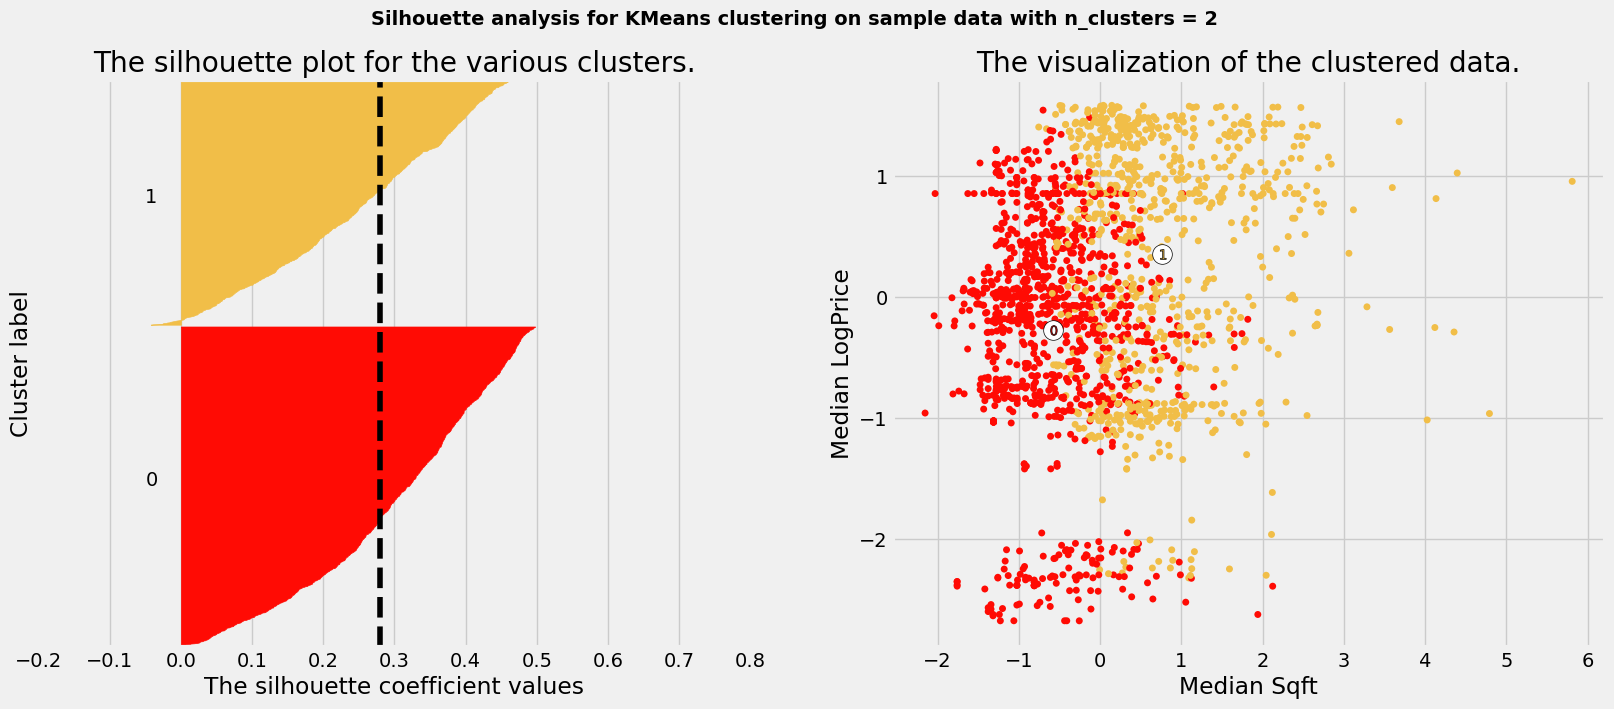

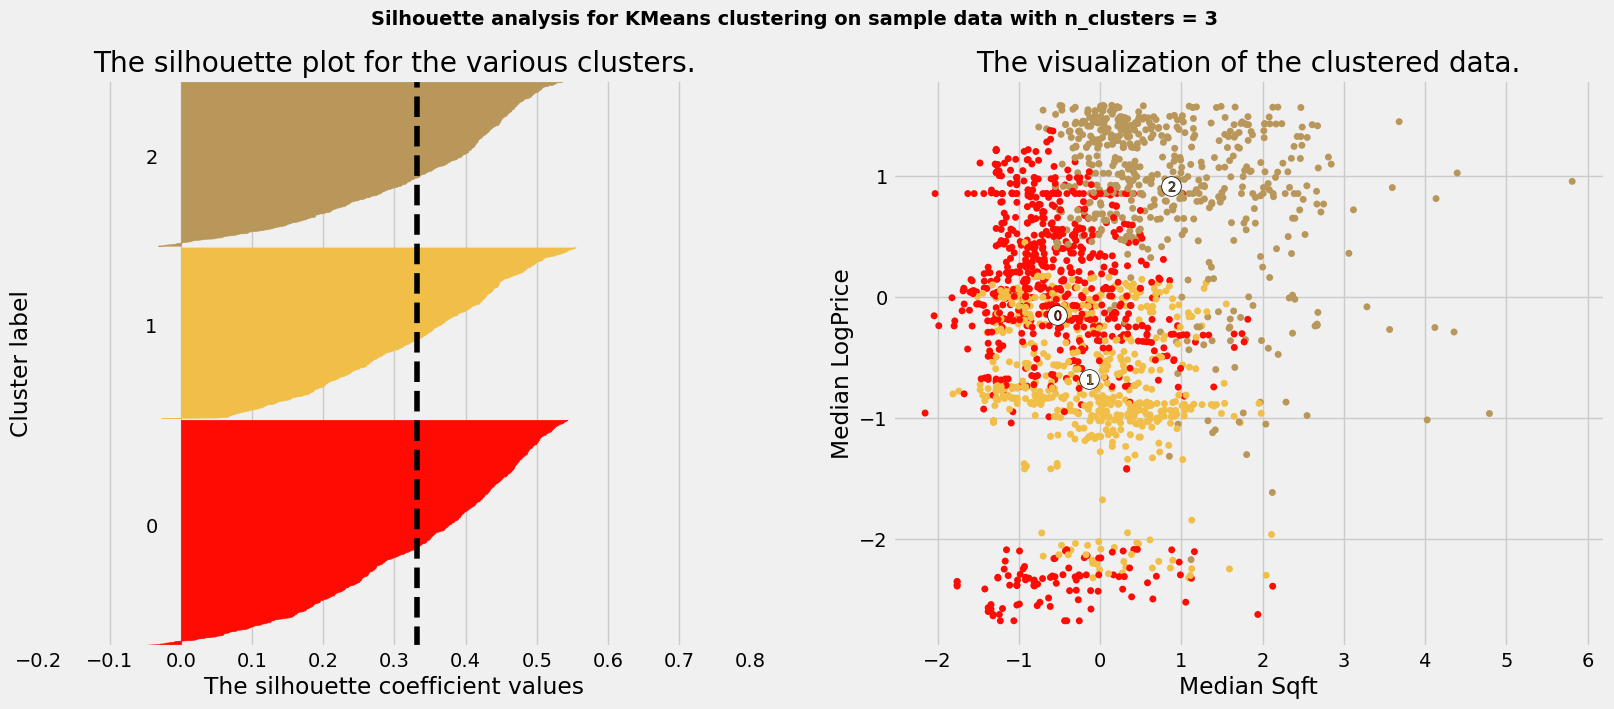

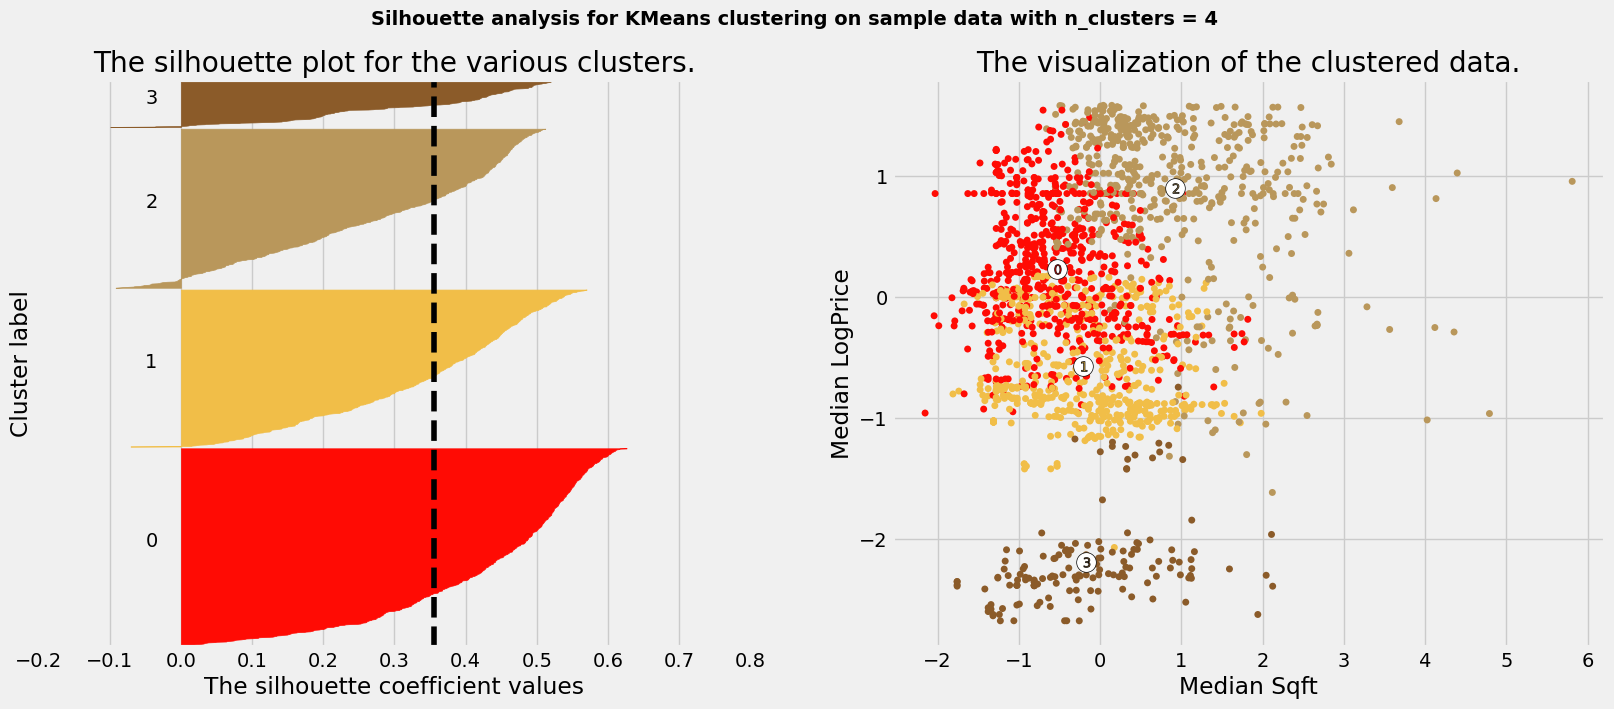

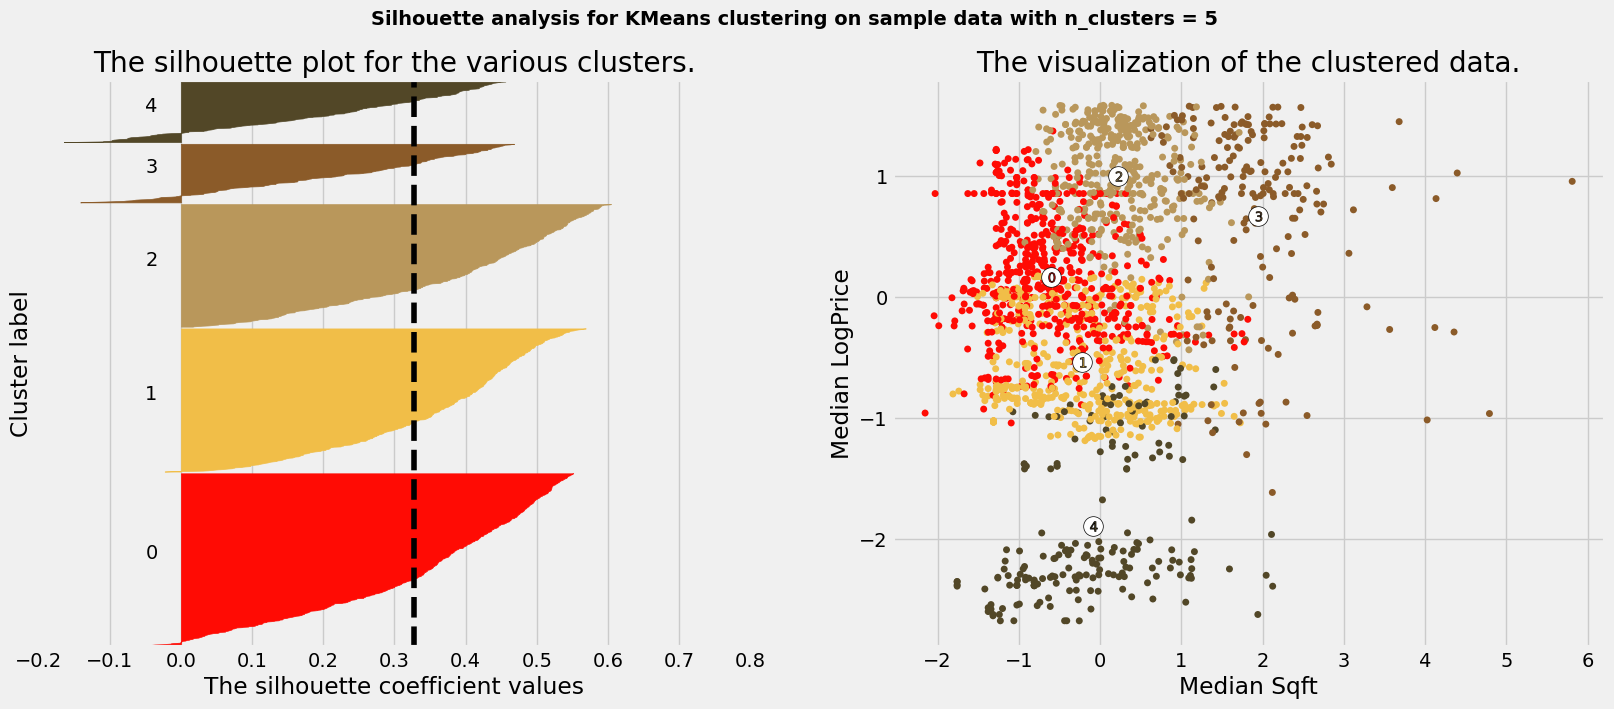

In [20]:
def cluster_graphs(df, cols, cluster_max=5, test=0):

    nhds = df.loc[:,cols]
    nhds['LogSalePrice'] = np.log(df['SalePrice'])

    scaler = StandardScaler()


    X = nhds
    X = scaler.fit_transform(X)

    inertias = []

    range_n_clusters = [2, 3, 4, 5]
    colors_silhouette_dict = {0:"#FF0B04", 
                              1:"#F1BE48",
                              2:"#B9975B", 
                              3:"#8B5B29",
                              4:"#524727",
                             }


    for n_clusters in range_n_clusters:

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        ax1.set_xlim([-0.2, 0.8])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 5])

        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = clusterer.fit_predict(X)

        inertias.append(clusterer.inertia_)

        silhouette_avg = silhouette_score(X, cluster_labels)
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 5

        for i in range(n_clusters):

            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = colors_silhouette_dict[i]
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=1)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 5

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="black", linestyle="--")

        ax1.set_yticks([])
        ax1.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

        colors = [colors_silhouette_dict[cluster] for cluster in cluster_labels]
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=100, lw=0, alpha=1,
                    c=colors, edgecolor='k')

        centers = clusterer.cluster_centers_

        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Median Sqft")
        ax2.set_ylabel("Median LogPrice")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

In [21]:
clusterer = KMeans(n_clusters=3, random_state=42)
cluster_labels = clusterer.fit_predict(X)
nhds['Cluster'] = cluster_labels
nhds.sort_values('Cluster')

GrLivArea   latitude  longitude  LogSalePrice  Cluster
935         904  42.033563 -93.622413     11.686879        0
615        1442  42.043949 -93.615287     11.969717        0
616        1432  41.988247 -93.602743     11.964001        0
618        1573  42.031561 -93.622590     12.000892        0
619        1328  42.042317 -93.625963     11.870600        0
...         ...        ...        ...           ...      ...
850        2726  42.051321 -93.655362     12.765688        2
1471       1256  42.047421 -93.647580     12.180755        2
1167       1484  42.050704 -93.635234     12.072541        2
508        1470  42.058139 -93.637030     12.128111        2
1020       2054  42.058869 -93.642028     12.404924        2

[1868 rows x 5 columns]

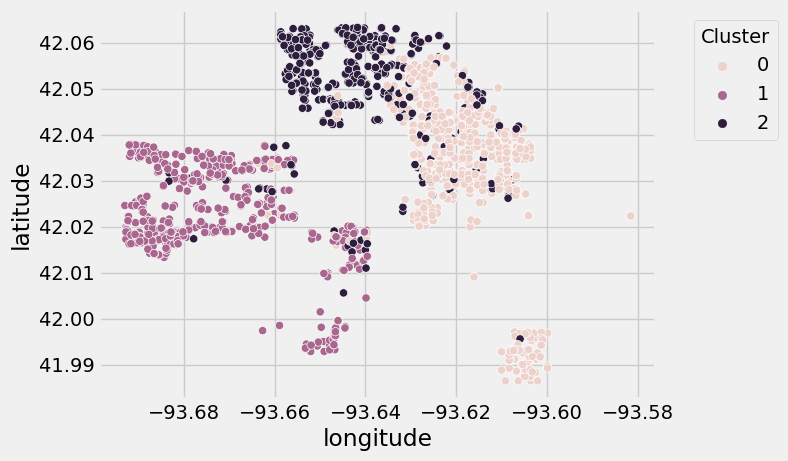

In [22]:
g = sns.scatterplot(data = nhds, y = 'latitude',x = 'longitude',
                    hue='Cluster',)
sns.move_legend(g,loc = "upper left",bbox_to_anchor=(1.05, 1))
plt.show()

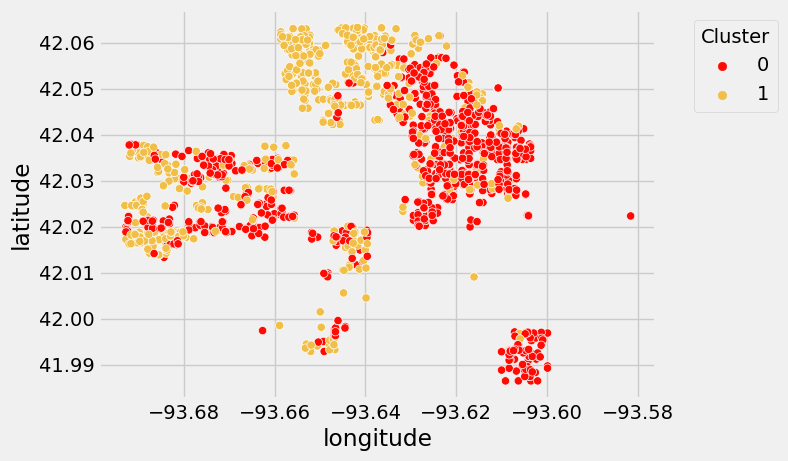

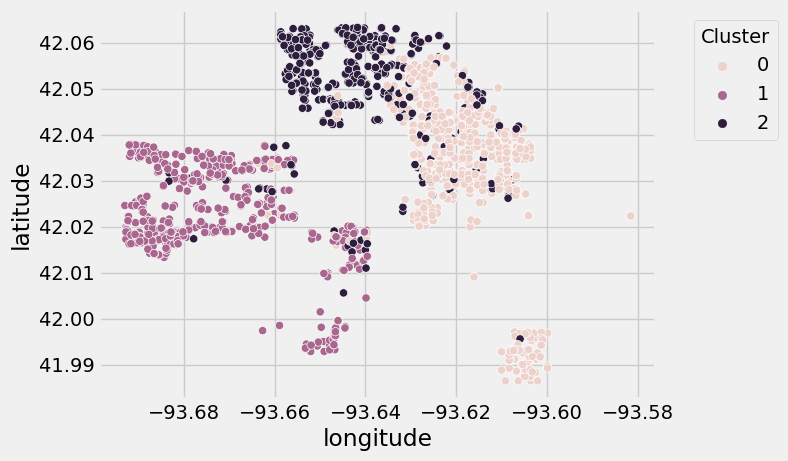

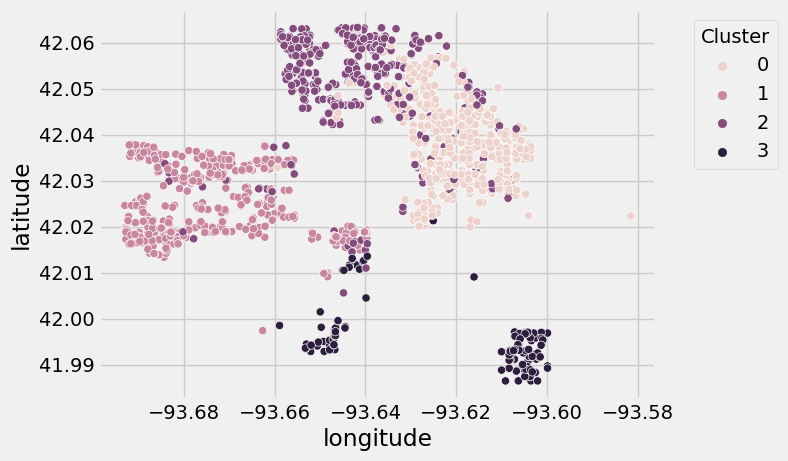

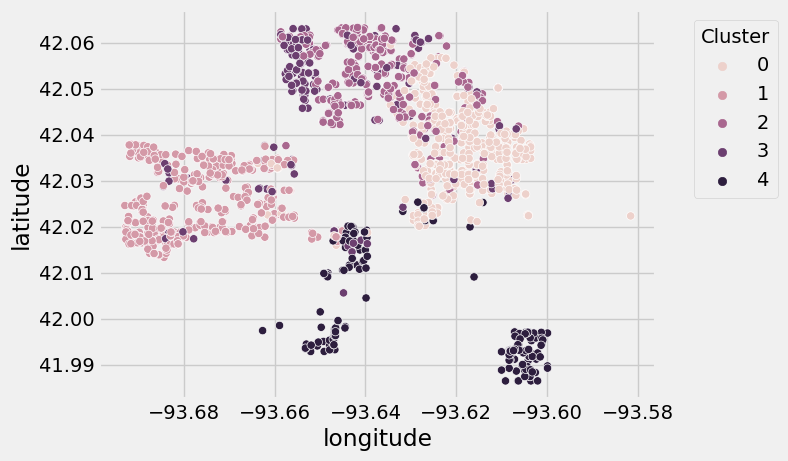

In [24]:
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    nhds['Cluster'] = cluster_labels
    nhds.sort_values('Cluster')
    
    g = sns.scatterplot(data = nhds, y = 'latitude',x = 'longitude',
                        hue='Cluster',)
    sns.move_legend(g,loc = "upper left",bbox_to_anchor=(1.05, 1))
    plt.show()

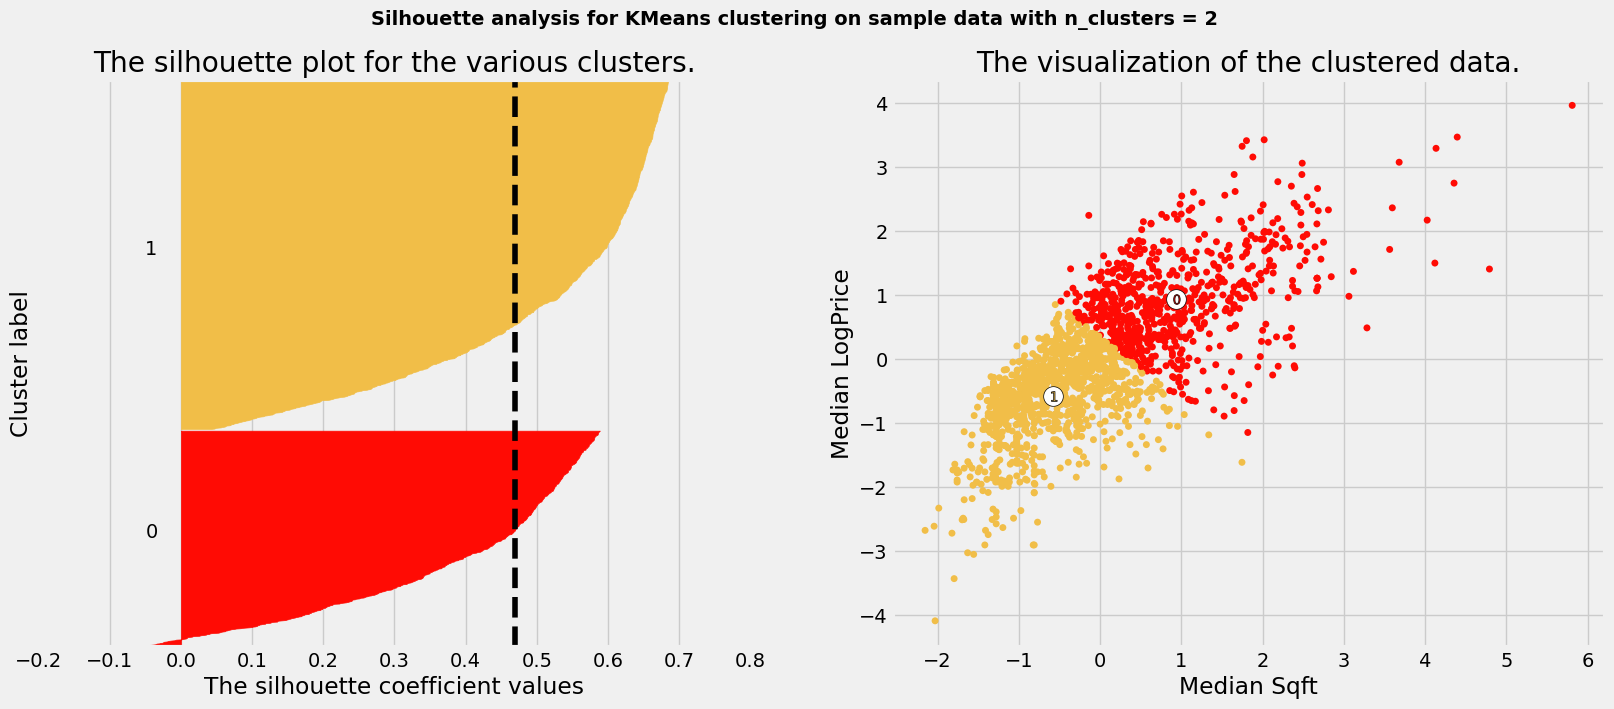

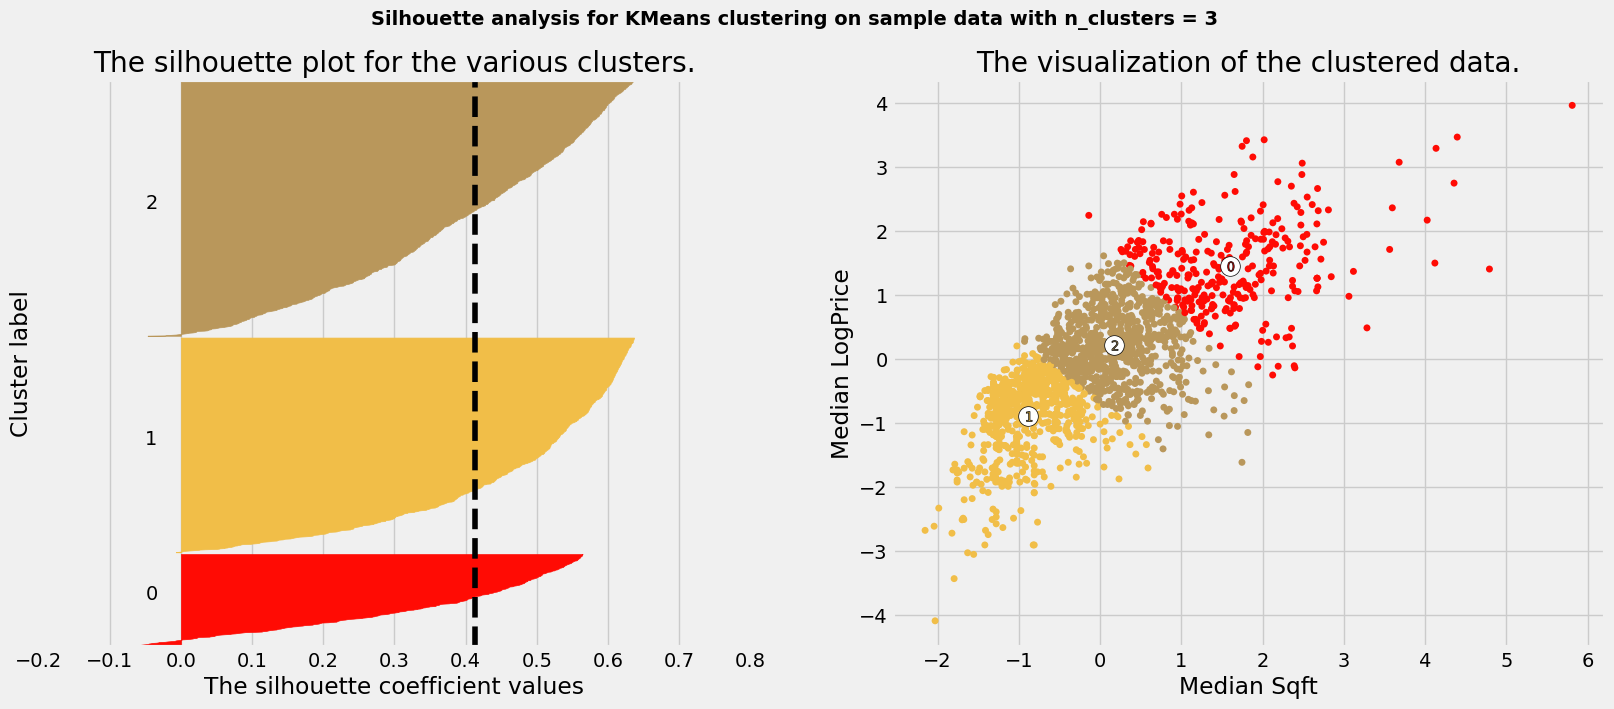

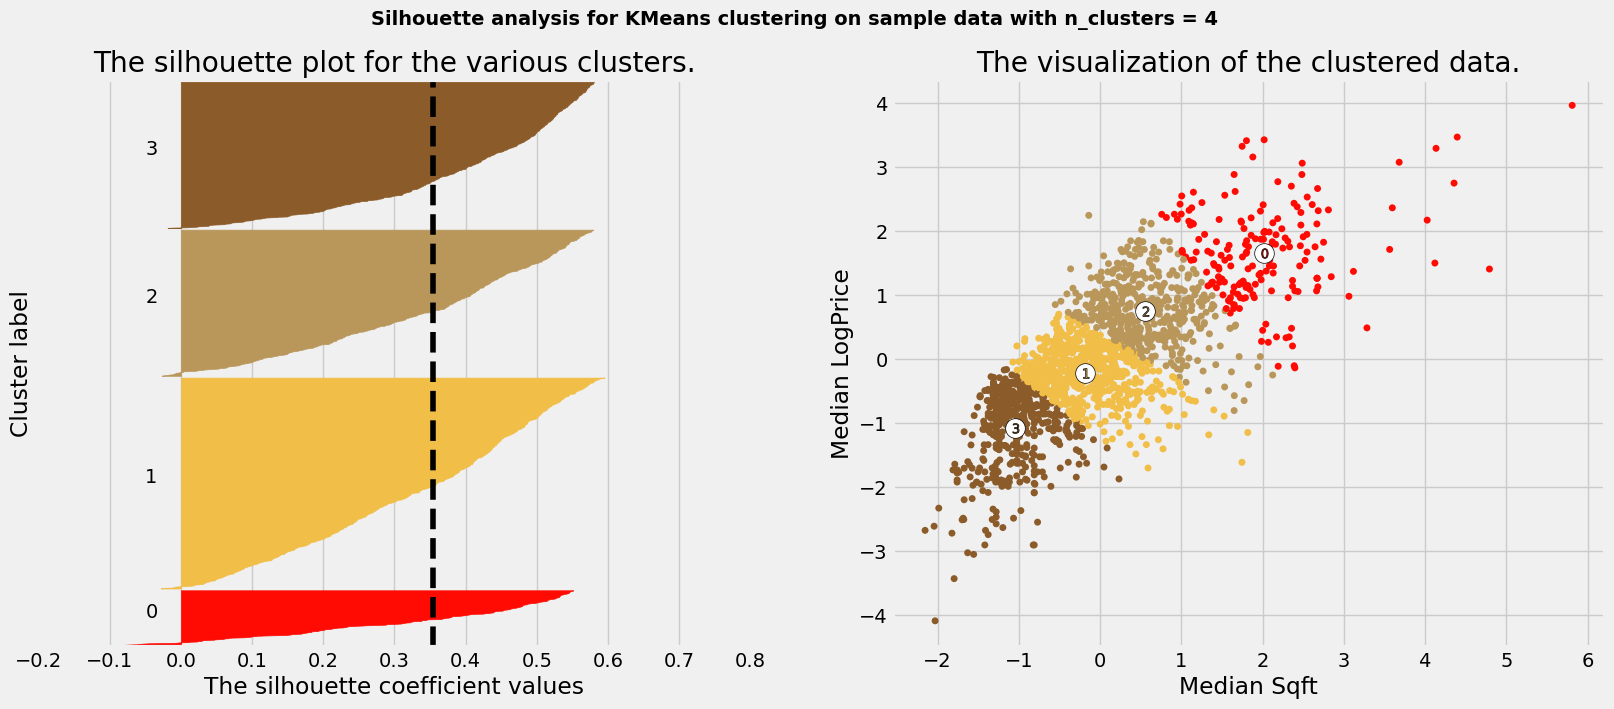

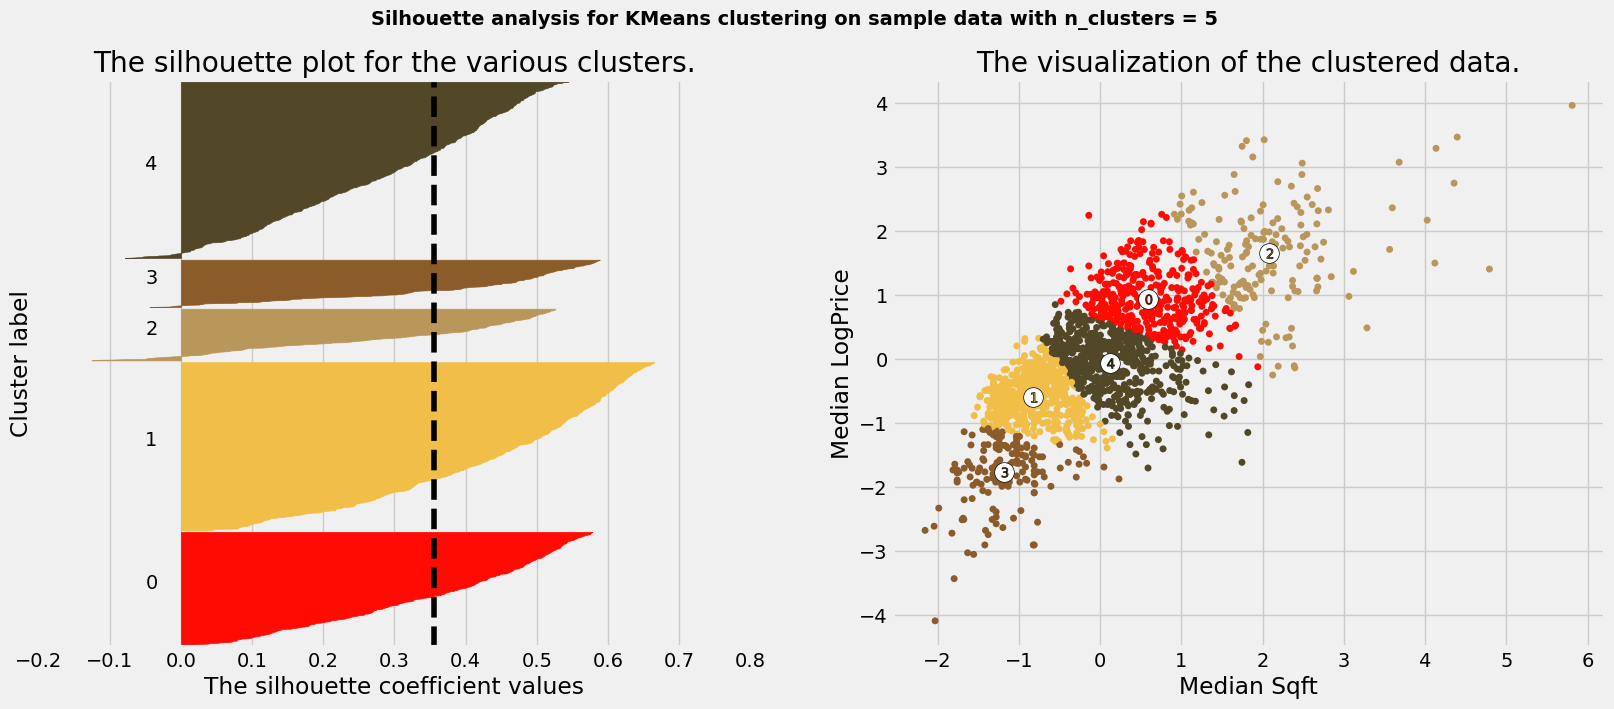

In [28]:
nhds = train.loc[:,['GrLivArea']]
nhds['LogSalePrice'] = np.log(train['SalePrice'])

scaler = StandardScaler()


X = nhds
X = scaler.fit_transform(X)

inertias = []

range_n_clusters = [2, 3, 4, 5]
colors_silhouette_dict = {0:"#FF0B04", 
                          1:"#F1BE48",
                          2:"#B9975B", 
                          3:"#8B5B29",
                          4:"#524727",
                         }


for n_clusters in range_n_clusters:
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    ax1.set_xlim([-0.2, 0.8])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 5])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    
    inertias.append(clusterer.inertia_)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 5
    
    for i in range(n_clusters):
        
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
    
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_silhouette_dict[i]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=1)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 5
        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="black", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

    colors = [colors_silhouette_dict[cluster] for cluster in cluster_labels]
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=100, lw=0, alpha=1,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Median Sqft")
    ax2.set_ylabel("Median LogPrice")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
plt.show()

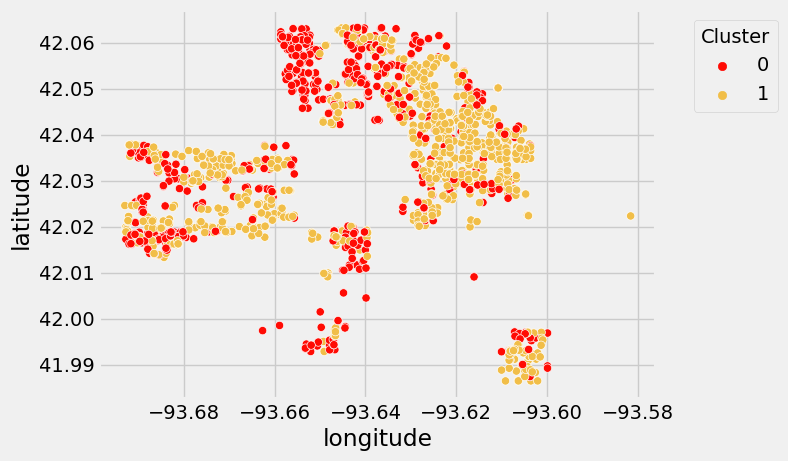

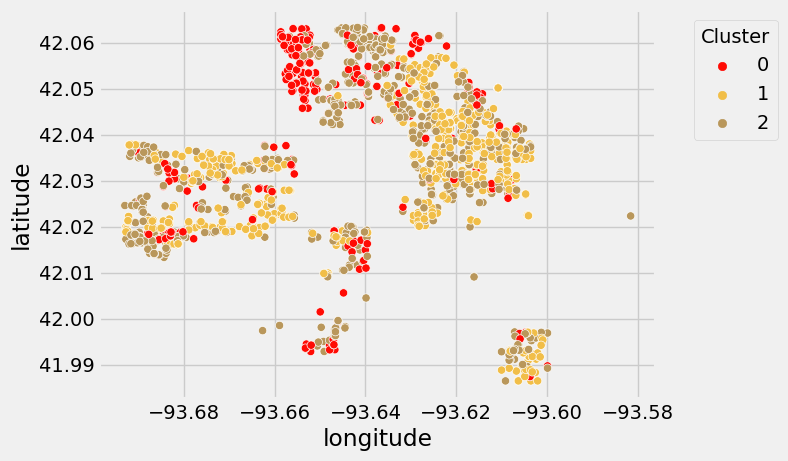

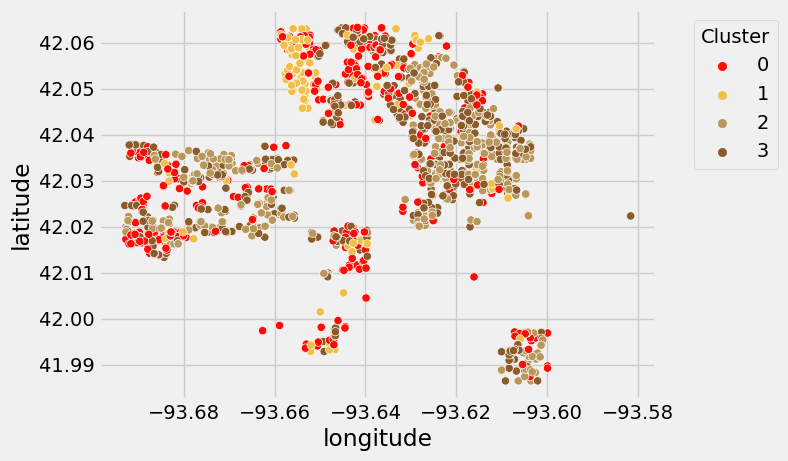

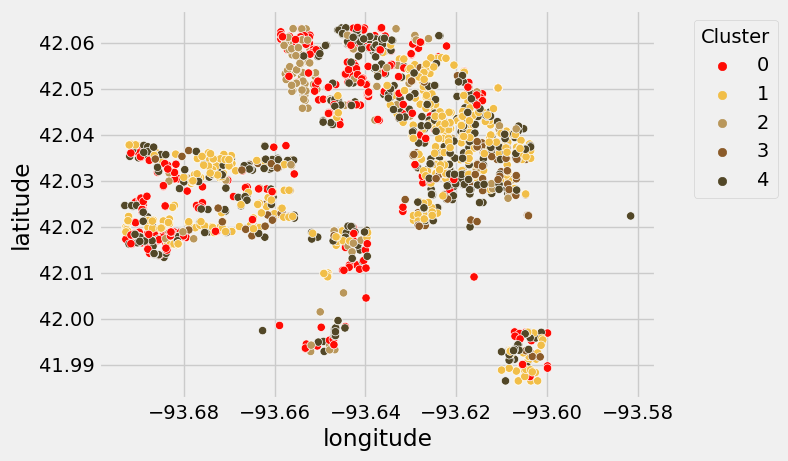

In [40]:
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    nhds['Cluster'] = cluster_labels
    nhds.sort_values('Cluster')
    nhds['latitude'] = train.loc[:,['latitude']]
    nhds['longitude'] = train.loc[:,['longitude']]
#     colors = [colors_silhouette_dict[cluster] for cluster in cluster_labels]


    g = sns.scatterplot(data = nhds, y = 'latitude',x = 'longitude',
                        hue='Cluster',palette = colors_silhouette_dict)
    sns.move_legend(g,loc = "upper left",bbox_to_anchor=(1.05, 1))
    plt.show()

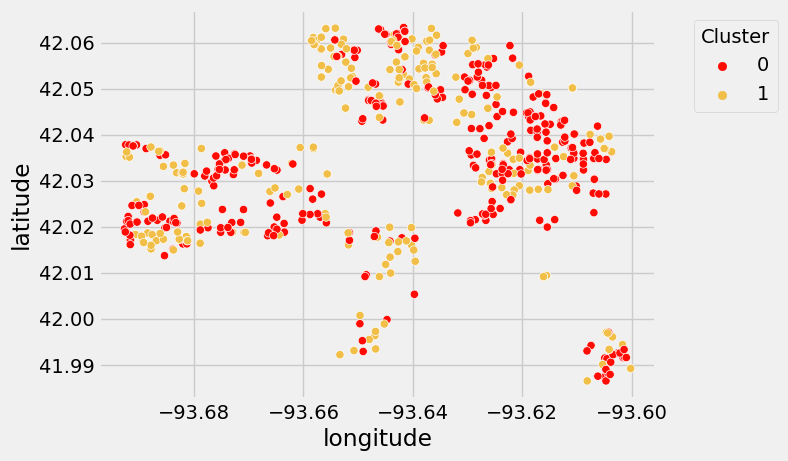

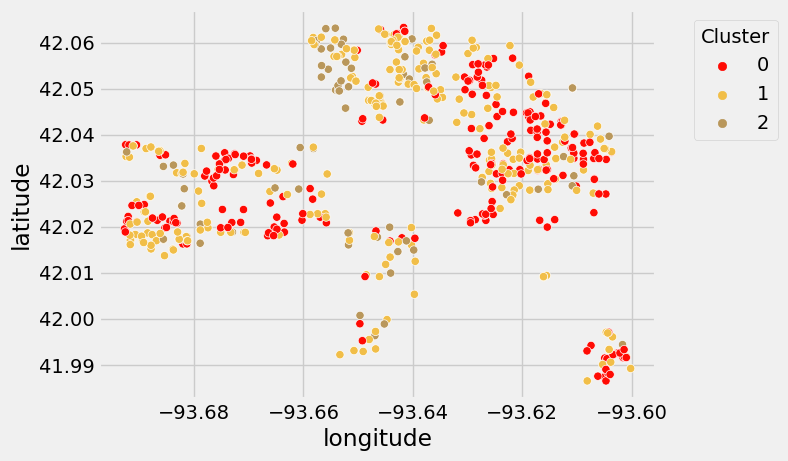

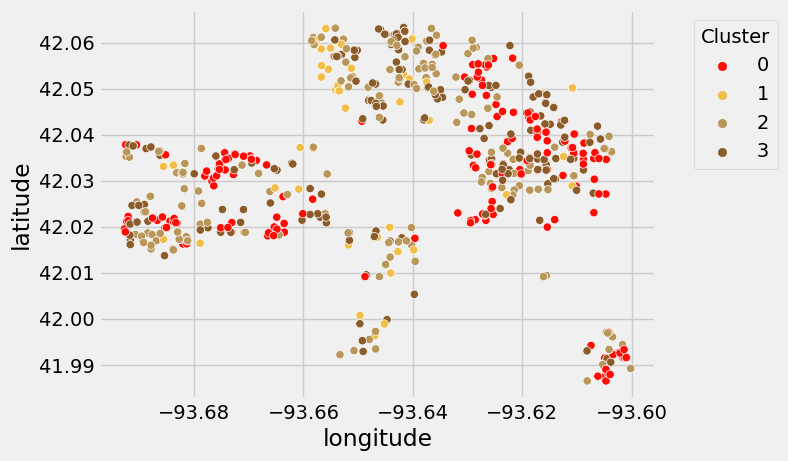

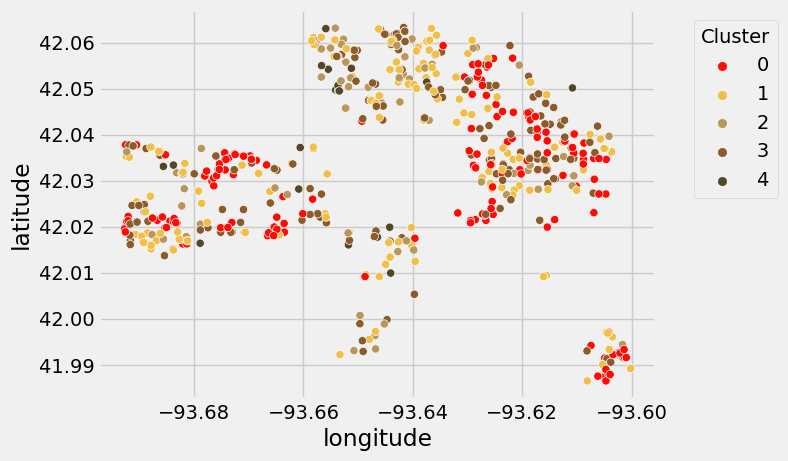

In [42]:
nhds_test = test.loc[:,['GrLivArea']]
nhds_test['LogSalePrice'] = np.log(test['SalePrice'])

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(nhds_test)
    nhds_test['Cluster'] = cluster_labels
    nhds_test.sort_values('Cluster')
    nhds_test['latitude'] = test.loc[:,['latitude']]
    nhds_test['longitude'] = test.loc[:,['longitude']]
#     colors = [colors_silhouette_dict[cluster] for cluster in cluster_labels]


    g = sns.scatterplot(data = nhds_test, y = 'latitude',x = 'longitude',
                        hue='Cluster',palette = colors_silhouette_dict)
    sns.move_legend(g,loc = "upper left",bbox_to_anchor=(1.05, 1))
    plt.show()

In [ ]:
# nhds_test, OverallQual

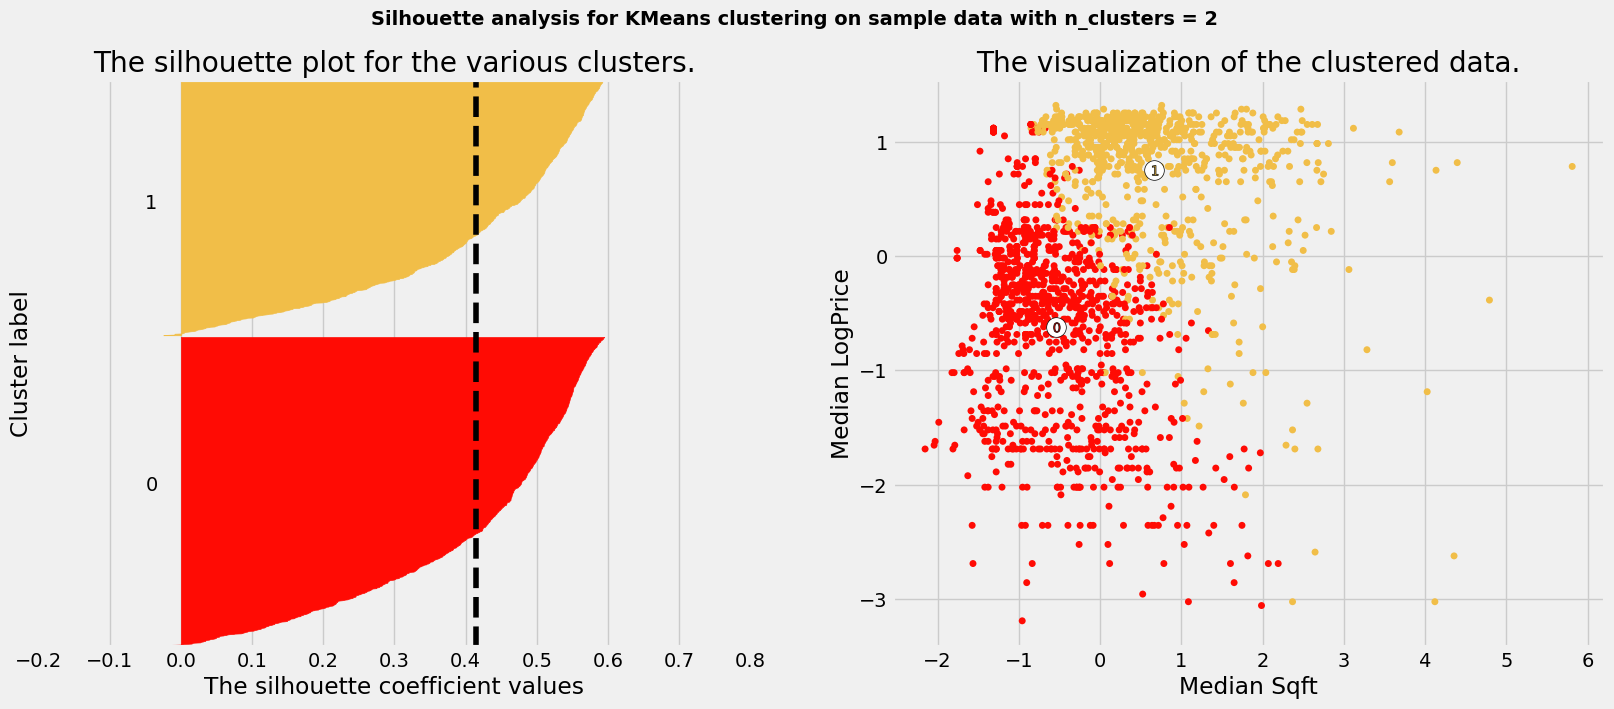

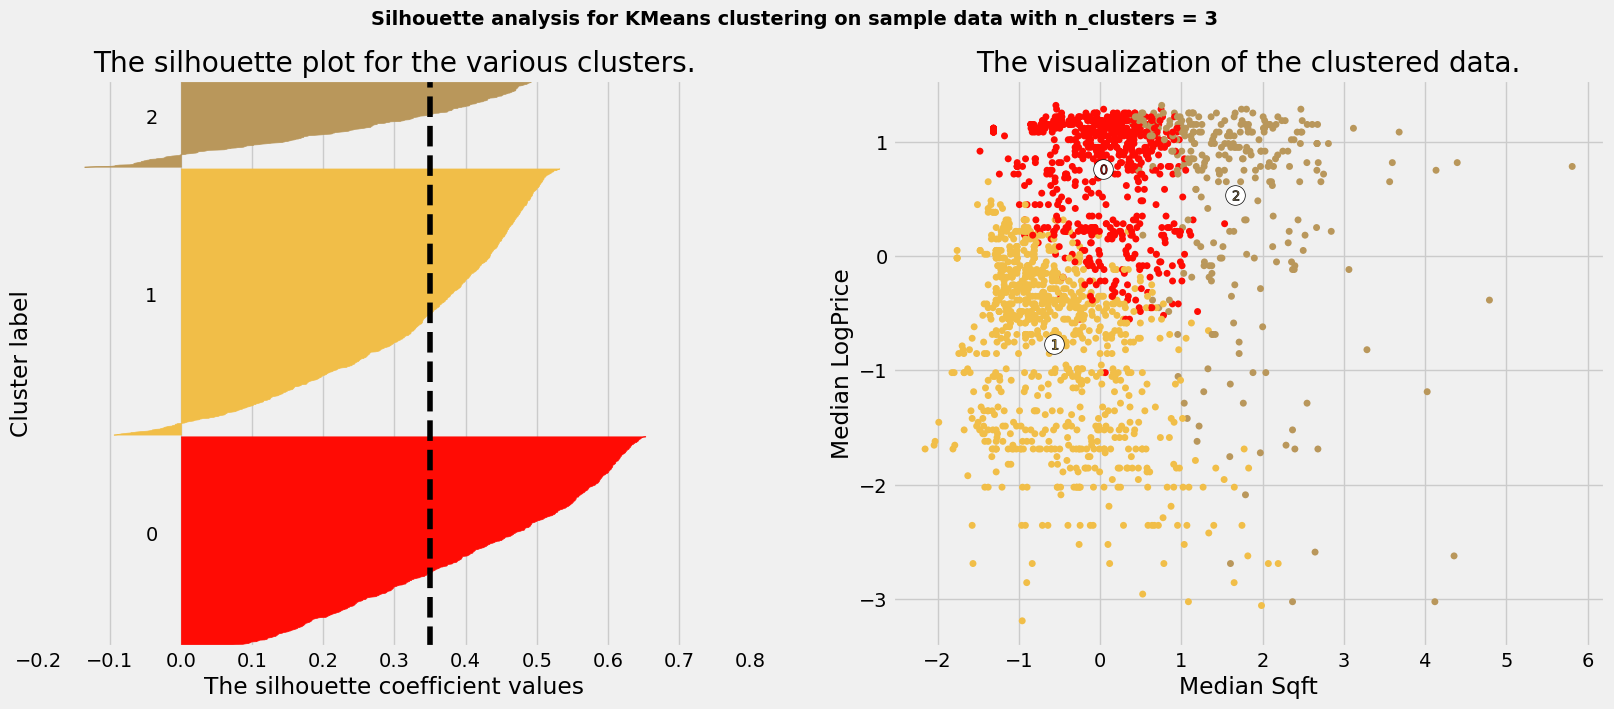

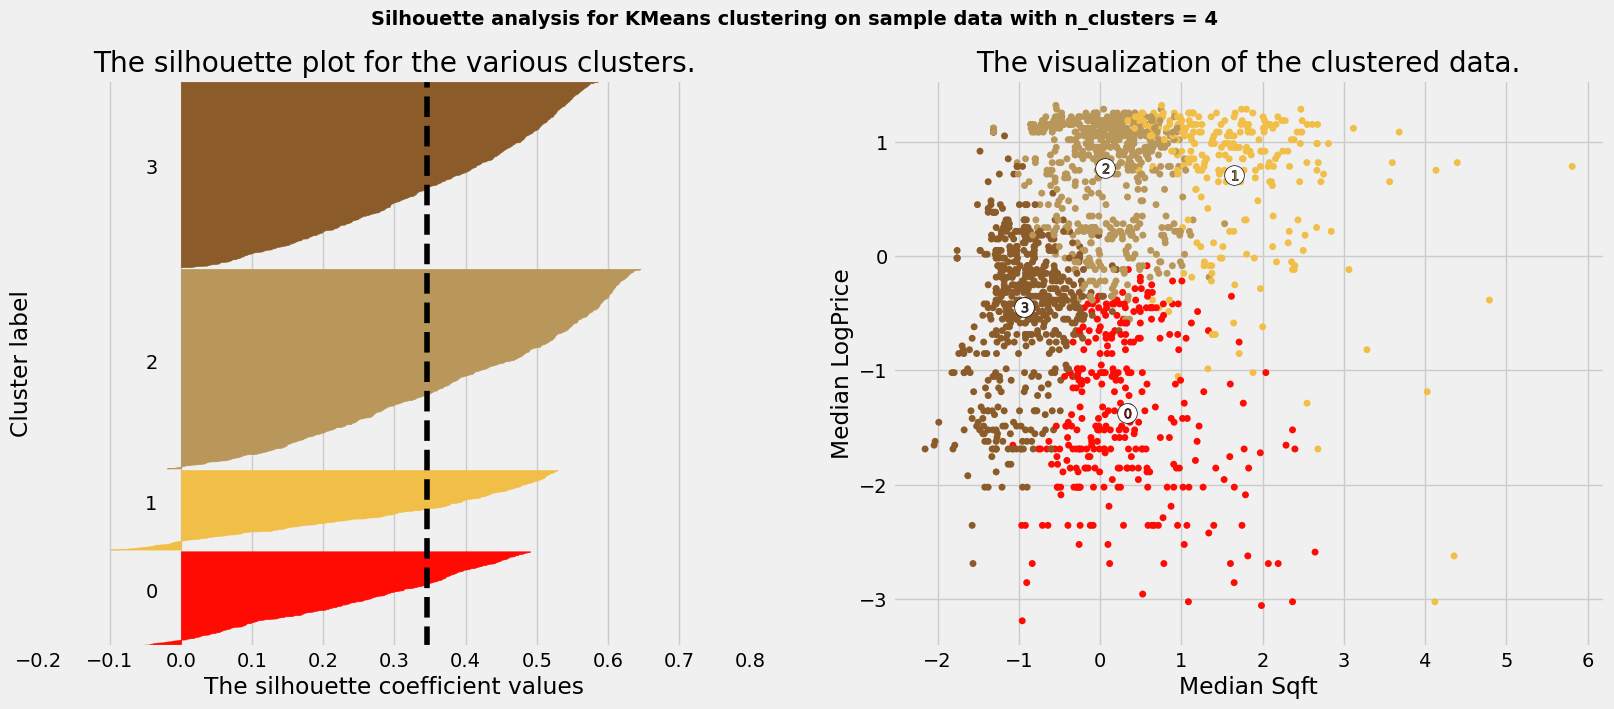

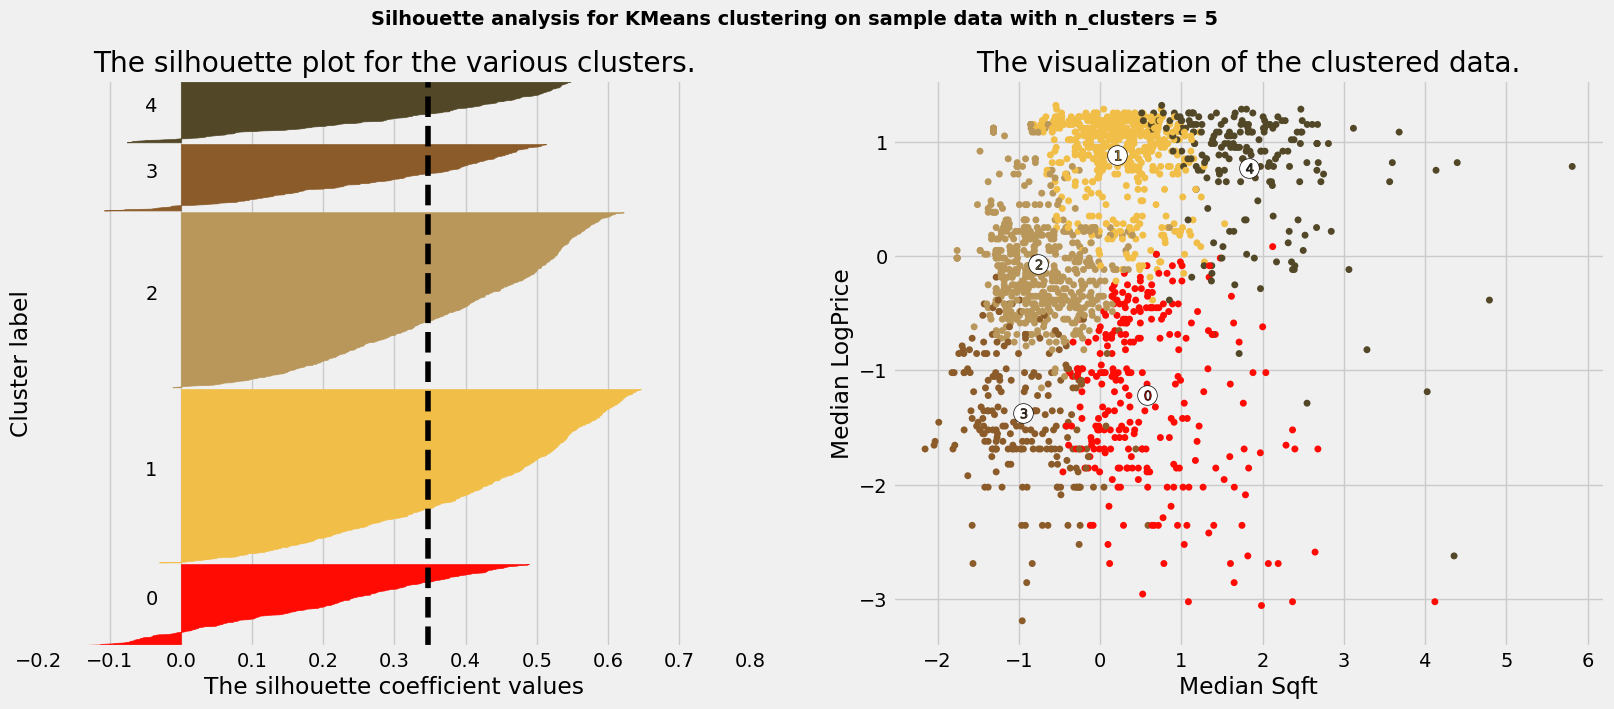

In [58]:
nhds = train.loc[:,['GrLivArea','YearBuilt',]]
nhds['LogSalePrice'] = np.log(train['SalePrice'])

scaler = StandardScaler()


X = nhds
X = scaler.fit_transform(X)

inertias = []

range_n_clusters = [2, 3, 4, 5]
colors_silhouette_dict = {0:"#FF0B04", 
                          1:"#F1BE48",
                          2:"#B9975B", 
                          3:"#8B5B29",
                          4:"#524727",
                         }


for n_clusters in range_n_clusters:
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    ax1.set_xlim([-0.2, 0.8])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 5])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    
    inertias.append(clusterer.inertia_)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 5
    
    for i in range(n_clusters):
        
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
    
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_silhouette_dict[i]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=1)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 5
        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="black", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

    colors = [colors_silhouette_dict[cluster] for cluster in cluster_labels]
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=100, lw=0, alpha=1,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Median Sqft")
    ax2.set_ylabel("Median LogPrice")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
plt.show()

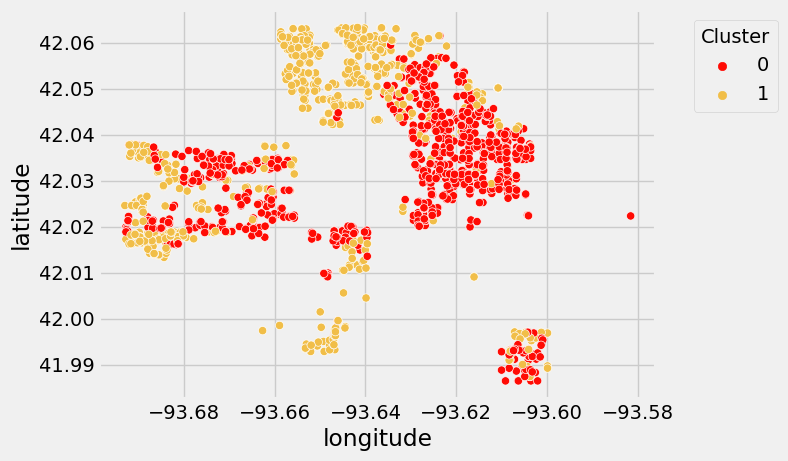

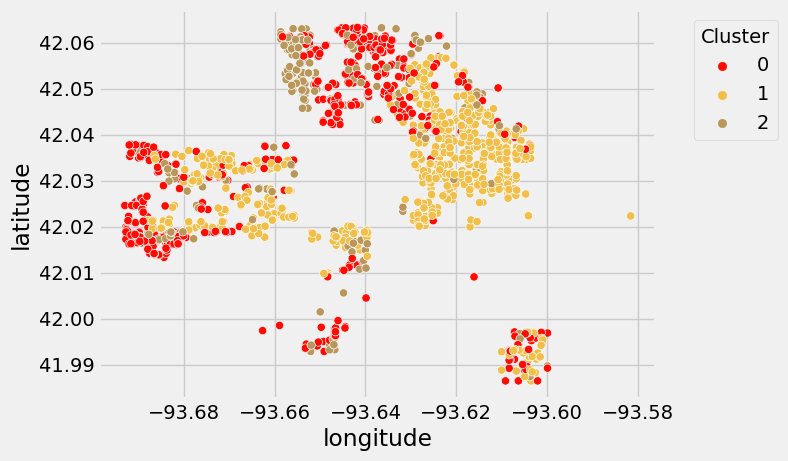

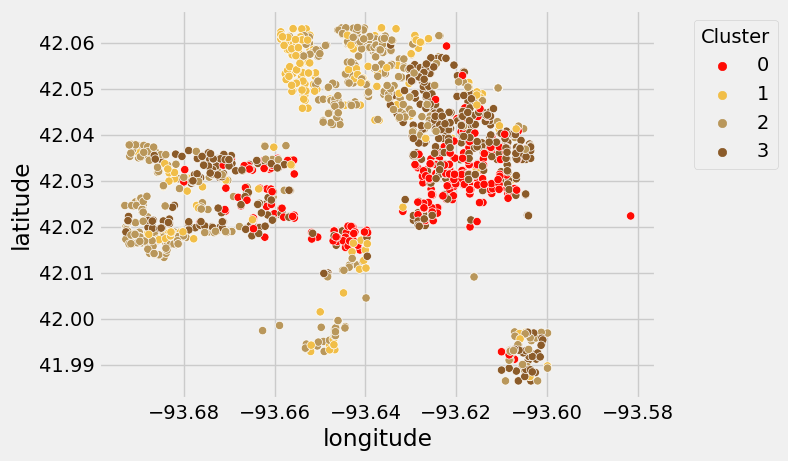

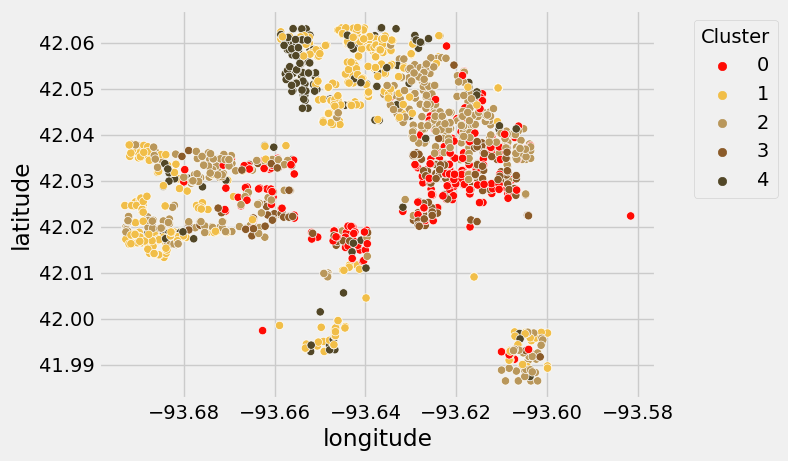

In [59]:
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    nhds['Cluster'] = cluster_labels
    nhds.sort_values('Cluster')
    nhds['latitude'] = train.loc[:,['latitude']]
    nhds['longitude'] = train.loc[:,['longitude']]
#     colors = [colors_silhouette_dict[cluster] for cluster in cluster_labels]


    g = sns.scatterplot(data = nhds, y = 'latitude',x = 'longitude',
                        hue='Cluster',palette = colors_silhouette_dict)
    sns.move_legend(g,loc = "upper left",bbox_to_anchor=(1.05, 1))
    plt.show()

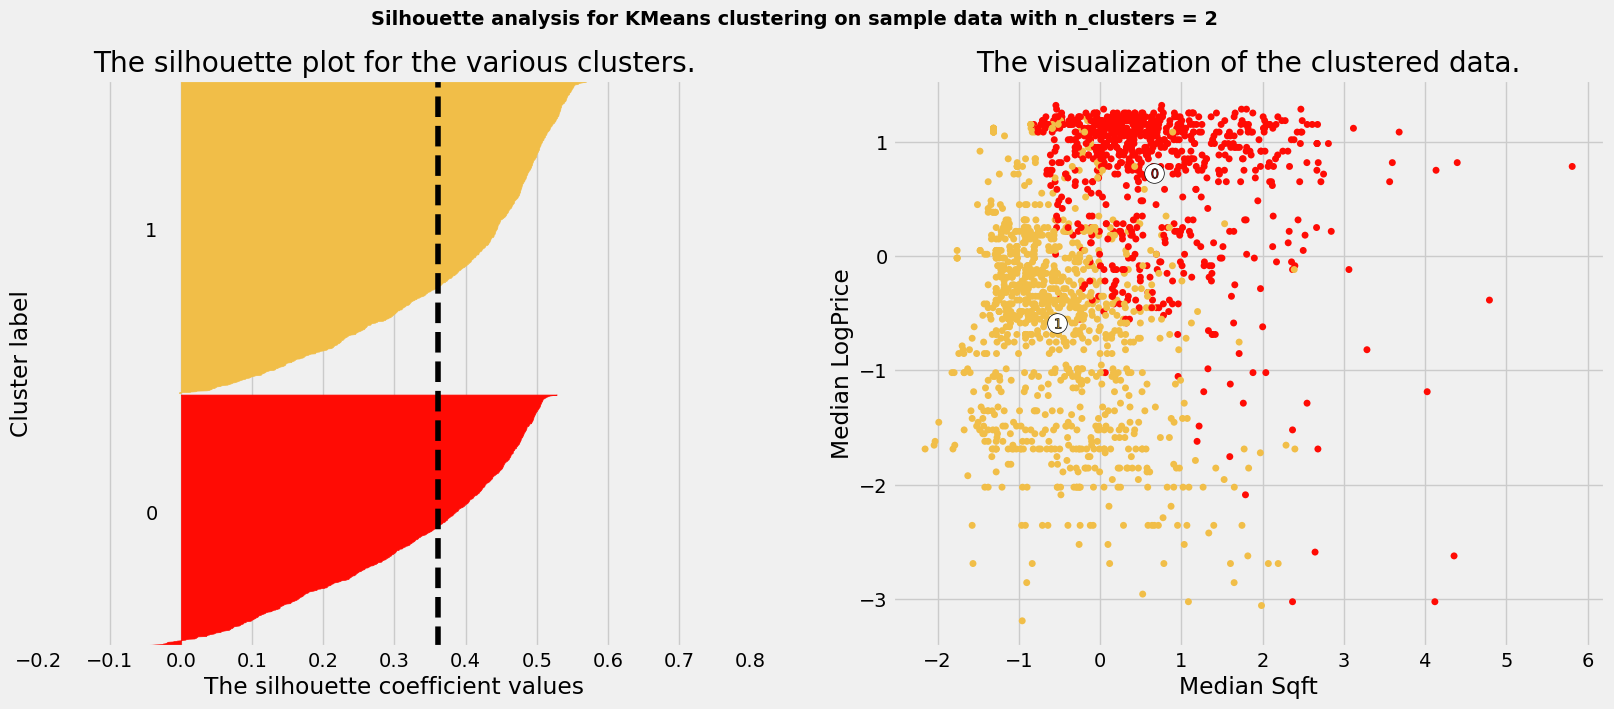

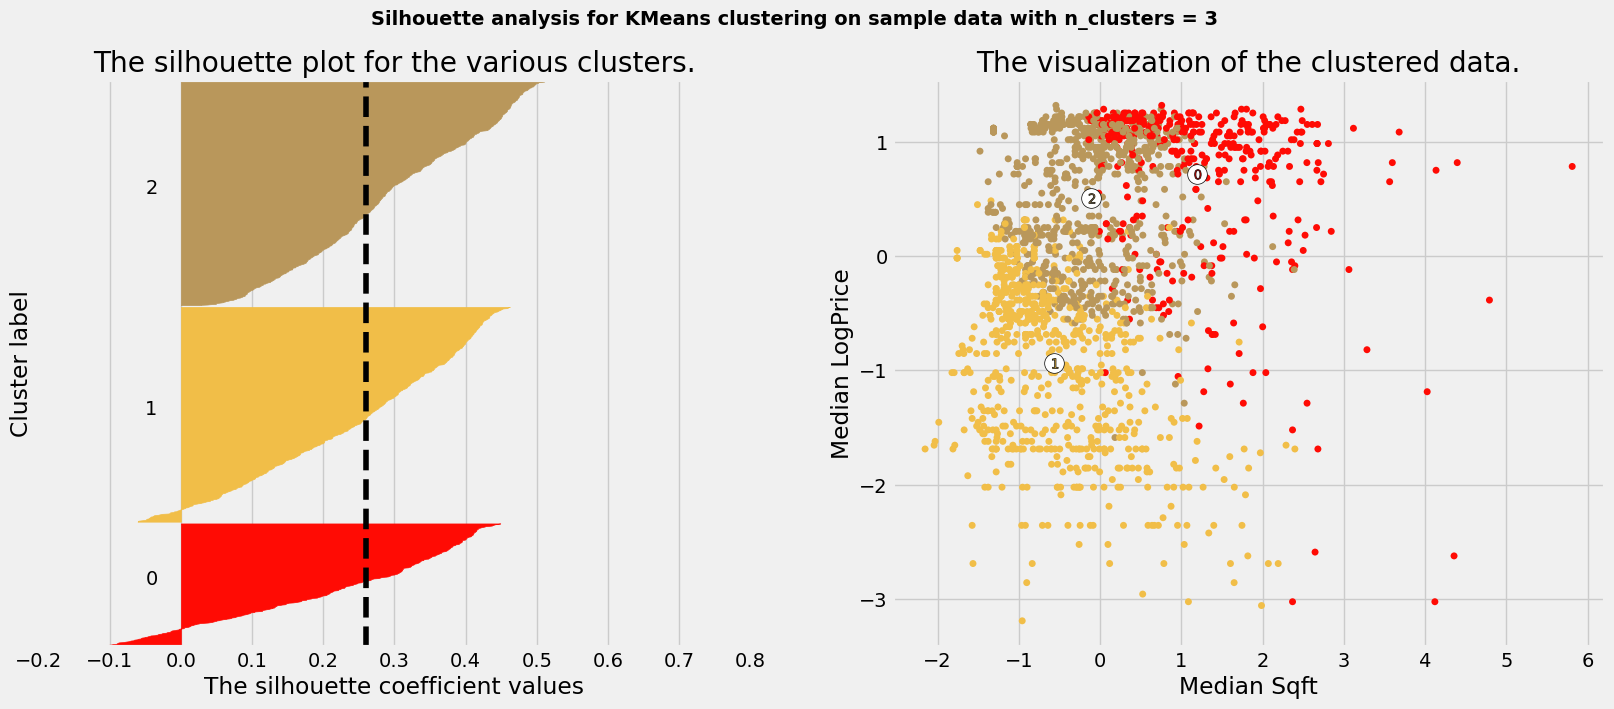

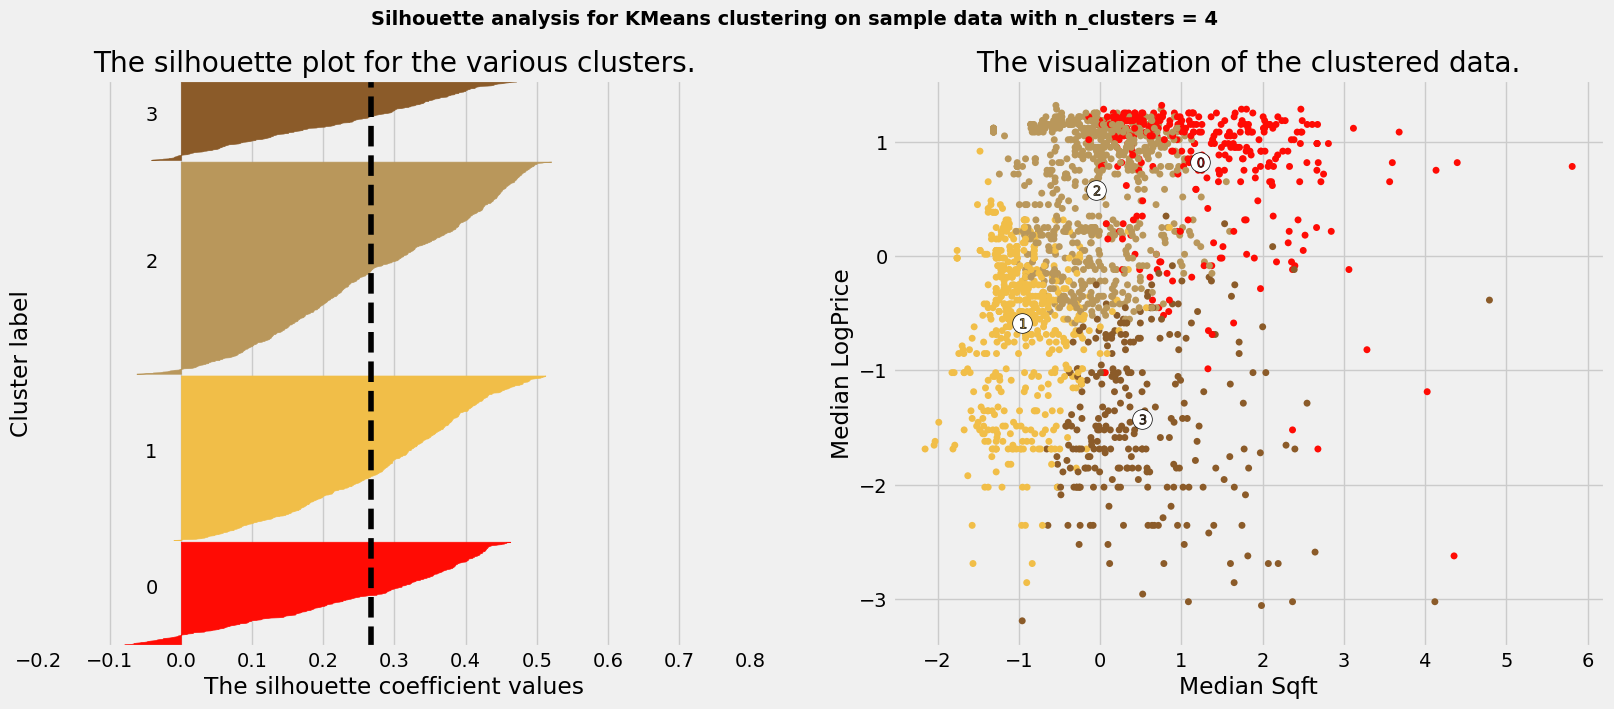

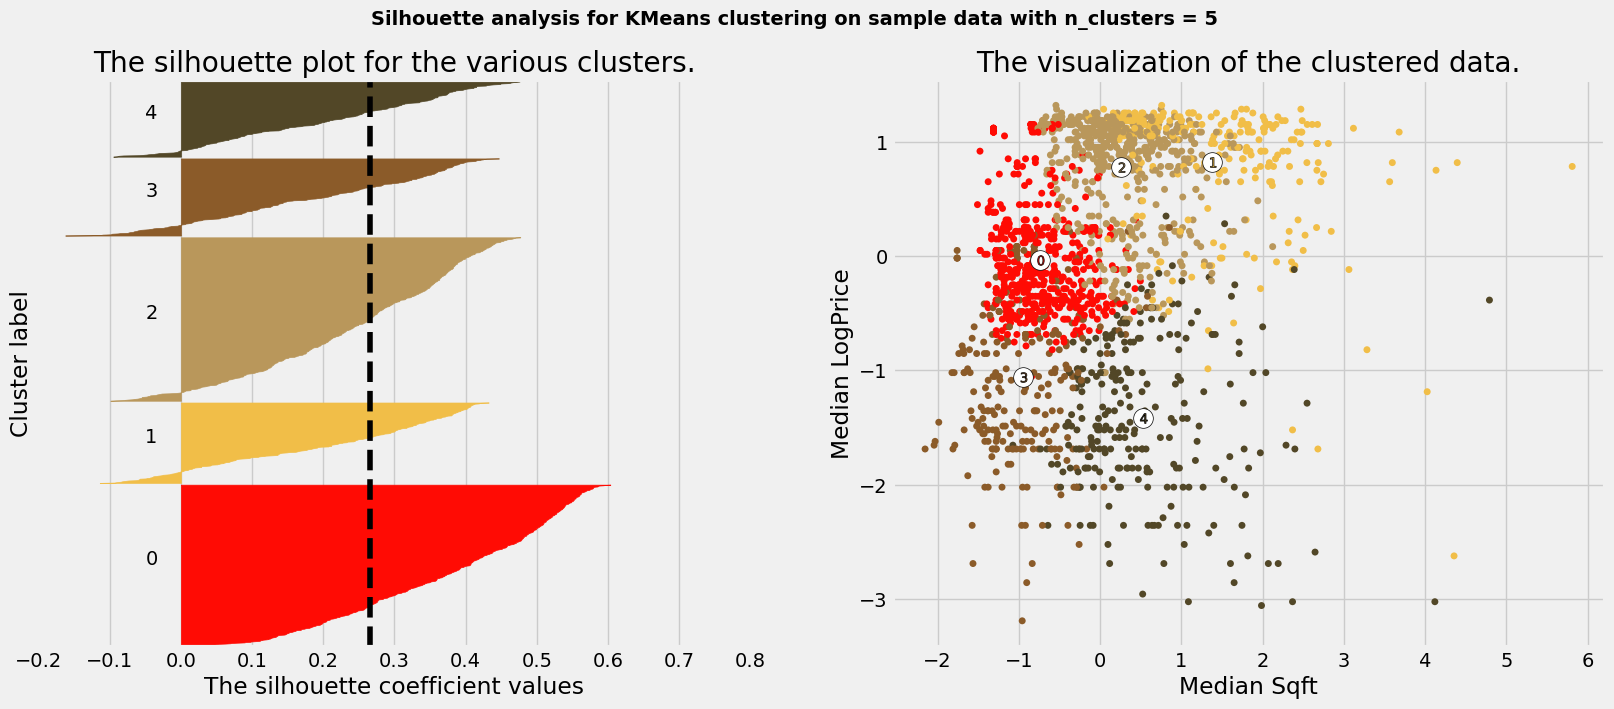

In [62]:
nhds = train.loc[:,['GrLivArea','YearBuilt','TotalBsmtSF']]
nhds['LogSalePrice'] = np.log(train['SalePrice'])

scaler = StandardScaler()


X = nhds
X = scaler.fit_transform(X)

inertias = []

range_n_clusters = [2, 3, 4, 5]
colors_silhouette_dict = {0:"#FF0B04", 
                          1:"#F1BE48",
                          2:"#B9975B", 
                          3:"#8B5B29",
                          4:"#524727",
                         }


for n_clusters in range_n_clusters:
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    ax1.set_xlim([-0.2, 0.8])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 5])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    
    inertias.append(clusterer.inertia_)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 5
    
    for i in range(n_clusters):
        
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
    
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_silhouette_dict[i]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=1)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 5
        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="black", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

    colors = [colors_silhouette_dict[cluster] for cluster in cluster_labels]
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=100, lw=0, alpha=1,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Median Sqft")
    ax2.set_ylabel("Median LogPrice")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
plt.show()

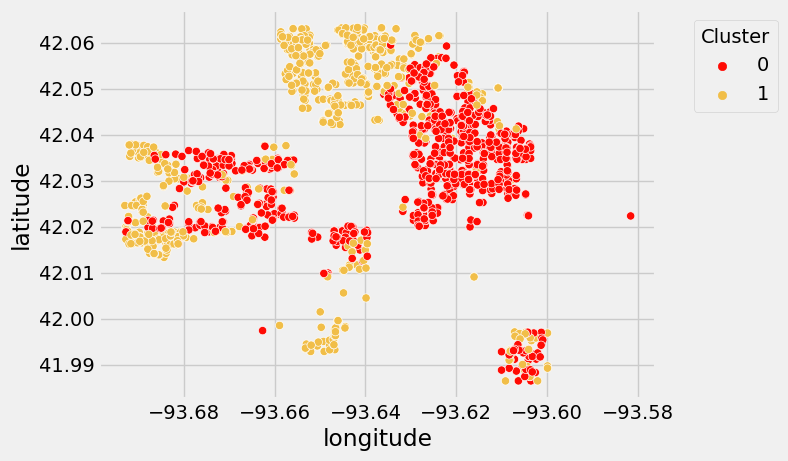

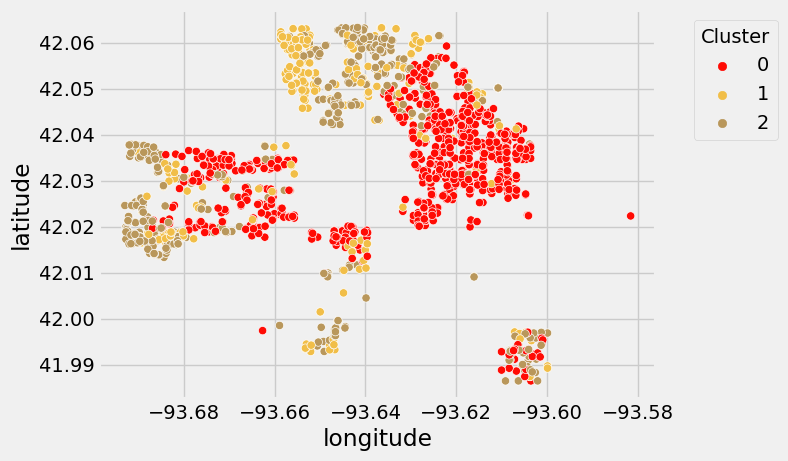

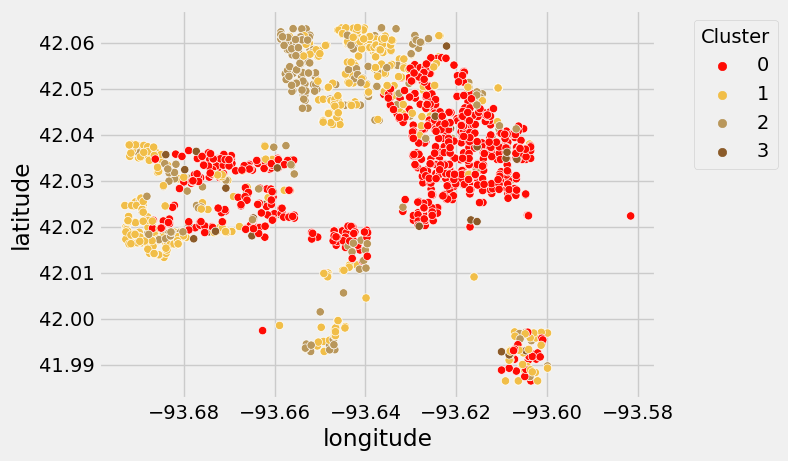

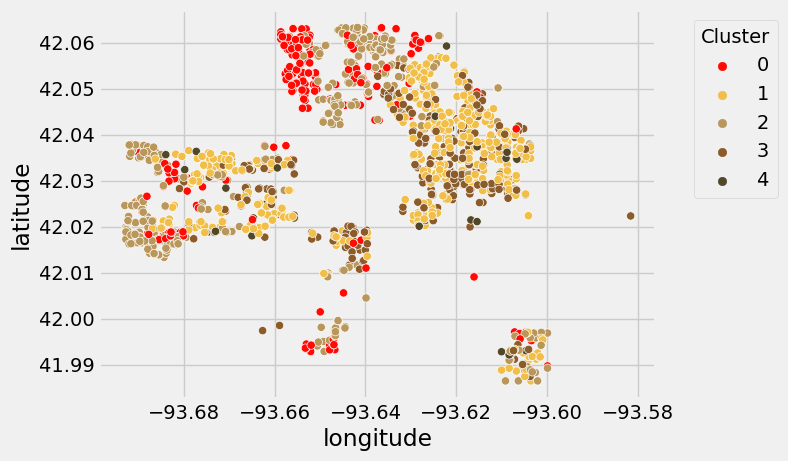

In [61]:
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    nhds['Cluster'] = cluster_labels
    nhds.sort_values('Cluster')
    nhds['latitude'] = train.loc[:,['latitude']]
    nhds['longitude'] = train.loc[:,['longitude']]
#     colors = [colors_silhouette_dict[cluster] for cluster in cluster_labels]


    g = sns.scatterplot(data = nhds, y = 'latitude',x = 'longitude',
                        hue='Cluster',palette = colors_silhouette_dict)
    sns.move_legend(g,loc = "upper left",bbox_to_anchor=(1.05, 1))
    plt.show()

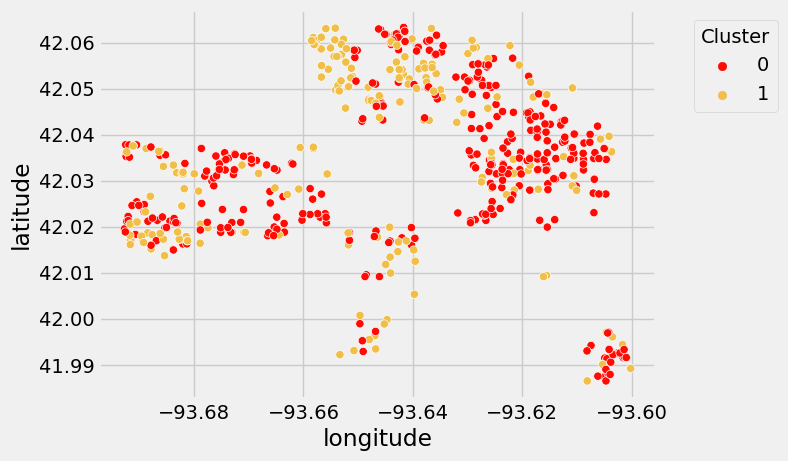

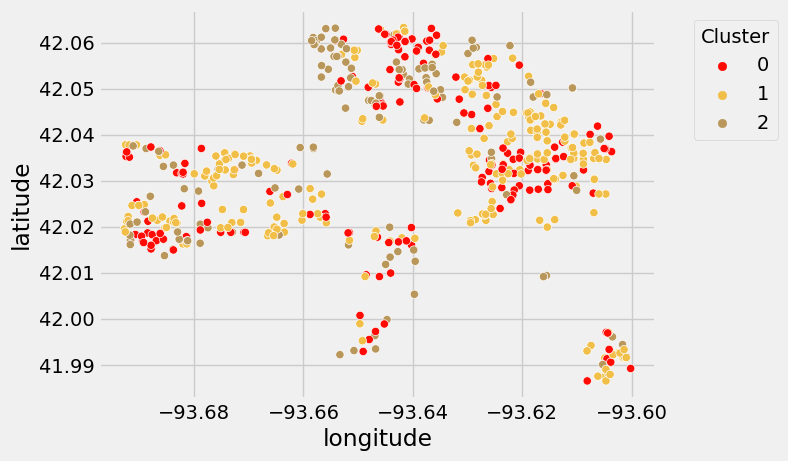

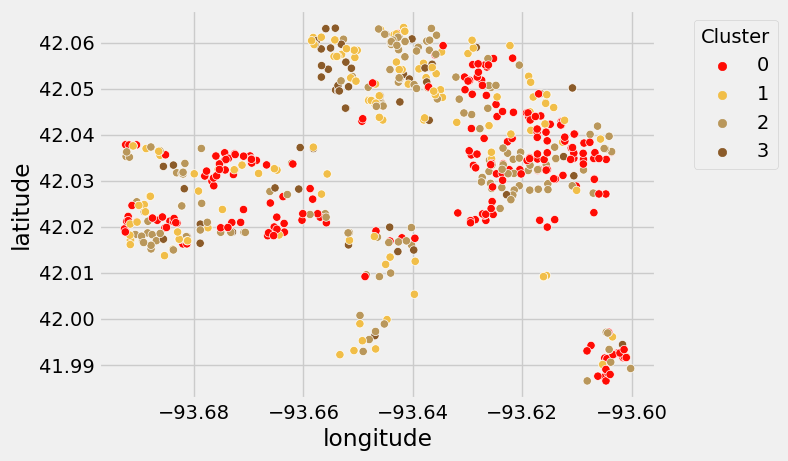

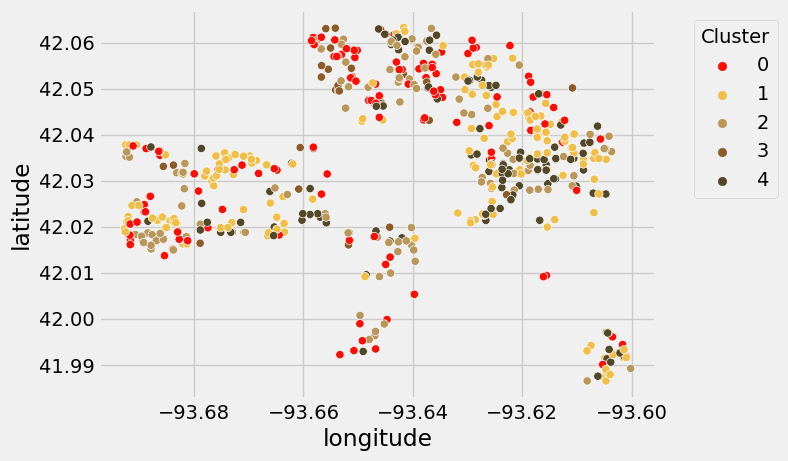

In [65]:
range_n_clusters = [2, 3, 4, 5]
nhds_test = test.loc[:,['GrLivArea','YearBuilt','TotalBsmtSF']]


for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(nhds_test)
    nhds_test['Cluster'] = cluster_labels
    nhds_test.sort_values('Cluster')
    nhds_test['latitude'] = test.loc[:,['latitude']]
    nhds_test['longitude'] = test.loc[:,['longitude']]
#     colors = [colors_silhouette_dict[cluster] for cluster in cluster_labels]


    g = sns.scatterplot(data = nhds_test, y = 'latitude',x = 'longitude',
                        hue='Cluster',palette = colors_silhouette_dict)
    sns.move_legend(g,loc = "upper left",bbox_to_anchor=(1.05, 1))
    plt.show()